# Enhanced S&P 500 Backtesting with Machine Learning
Combines multi-stock data with ML predictions for trading signals.

In [68]:
import pandas as pd
import numpy as np
import backtrader as bt
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from collections import Counter


## Data Loading & Feature Engineering
Load S&P 500 data and prepare ML features/labels.

In [69]:
def load_sp500_data(ticker='NVDA'):
    # Load full S&P 500 dataset
    df = pd.read_csv('../sp500data/SP500PriceHistory.csv', index_col='Date', parse_dates=True)
    
    # Select target ticker and calculate returns
    prices = df[[ticker]].copy()
    prices['Returns'] = prices[ticker].pct_change(fill_method=None)  # Explicit no filling
    
    # Calculate future returns for labeling
    hm_days = 7
    for i in range(1, hm_days+1):
        # Calculate percentage change without automatic filling
        shifted = prices[ticker].shift(-i)
        prices[f'{i}d_future'] = (shifted - prices[ticker]) / prices[ticker]
    
    # Forward fill then drop remaining NaNs
    prices.ffill(inplace=True)
    prices.dropna(inplace=True)
    
    return prices

data = load_sp500_data('NVDA')
print("Data Head:\n", data.head(3))

Data Head:
                 NVDA   Returns  1d_future  2d_future  3d_future  4d_future  \
Date                                                                         
2018-01-03  5.254336  0.065814   0.005271   0.013790   0.044853   0.044571   
2018-01-04  5.282033  0.005271   0.008474   0.039374   0.039094   0.047240   
2018-01-05  5.326795  0.008474   0.030640   0.030362   0.038440   0.040297   

            5d_future  6d_future  7d_future  
Date                                         
2018-01-03   0.052760   0.054643   0.049466  
2018-01-04   0.049113   0.043963   0.030526  
2018-01-05   0.035190   0.021866   0.043268  


In [70]:
def buy_sell_hold(*args):
    requirement = 0.02
    for col in args:
        if col > requirement:
            return 1
        if col < -requirement:
            return -1
    return 0

# Create labels and features with strict validation
data['Label'] = [buy_sell_hold(*row) for row in data[['1d_future','2d_future','3d_future',
                                                     '4d_future','5d_future','6d_future',
                                                     '7d_future']].values]

# Generate features with explicit length validation
feature_names = []
for i in range(15):  # 0-14 features
    col_name = f'Ret_{i}d' if i > 0 else 'Returns'
    feature_names.append(col_name)
    data[col_name] = data['Returns'].shift(i)

# Clean data with strict column validation
features = data[feature_names].copy()
features.dropna(inplace=True)

# Verify feature dimensions
assert len(feature_names) == 15, "Must have exactly 15 features"
print("\nFeature Columns:", features.columns.tolist())
print("Feature Shape:", features.shape)


Feature Columns: ['Returns', 'Ret_1d', 'Ret_2d', 'Ret_3d', 'Ret_4d', 'Ret_5d', 'Ret_6d', 'Ret_7d', 'Ret_8d', 'Ret_9d', 'Ret_10d', 'Ret_11d', 'Ret_12d', 'Ret_13d', 'Ret_14d']
Feature Shape: (1760, 15)


In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    features, data['Label'].iloc[-len(features):], test_size=0.25, shuffle=False)

clf = VotingClassifier([
    ('lsvc', LinearSVC(C=0.5, dual=False)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('rfc', RandomForestClassifier(n_estimators=100))
])
clf.fit(X_train, y_train)

print(f"\nModel Accuracy: {clf.score(X_test, y_test):.2%}")


Model Accuracy: 55.45%


## Backtrader Strategy Implementation
ML-driven trading strategy with risk management.

In [72]:
class MLStrategy(bt.Strategy):
    params = (
        ('position_size', 0.03),  # 3% risk per trade
        ('hard_stop', 0.05),      # 5% stop loss
        ('take_profit', 0.08),    # 8% take profit
        ('max_drawdown', 0.15),   # 15% portfolio drawdown limit
        ('daily_trades', 1),      # Max 1 trade per day
    )

    def __init__(self):
        # Initialize model and data references
        self.ml_model = clf
        self.data_close = self.datas[0].close
        self.peak_equity = self.broker.getvalue()
        self.current_position = None
        self.last_trade_date = None
        self.order = None
        
        # Feature configuration
        self.feature_names = [
            'Returns', 'Ret_1d', 'Ret_2d', 'Ret_3d', 'Ret_4d',
            'Ret_5d', 'Ret_6d', 'Ret_7d', 'Ret_8d', 'Ret_9d',
            'Ret_10d', 'Ret_11d', 'Ret_12d', 'Ret_13d', 'Ret_14d'
        ]
        
        # Drawdown tracking
        self.drawdown_alert = False
        self.equity = []

    def next(self):
        # Prevent trading during drawdown alert or existing orders
        if self.drawdown_alert or self.order:
            return
            
        # Check daily trade limit using current bar's date
        current_date = self.data.datetime.date(0)
        if current_date == self.last_trade_date:
            return

        # Calculate current drawdown
        current_equity = self.broker.getvalue()
        self.peak_equity = max(self.peak_equity, current_equity)
        drawdown = (self.peak_equity - current_equity) / self.peak_equity
        
        # Global circuit breaker
        if drawdown >= self.params.max_drawdown:
            self.drawdown_alert = True
            self.close()
            print(f"Drawdown limit reached: {drawdown:.2%}")
            return

        try:
            # Generate validated features
            current_features = [
                self.data_close[0]/self.data_close[-1] - 1,
                self.data_close[-1]/self.data_close[-2] - 1,
                self.data_close[-2]/self.data_close[-3] - 1,
                self.data_close[-3]/self.data_close[-4] - 1,
                self.data_close[-4]/self.data_close[-5] - 1,
                self.data_close[-5]/self.data_close[-6] - 1,
                self.data_close[-6]/self.data_close[-7] - 1,
                self.data_close[-7]/self.data_close[-8] - 1,
                self.data_close[-8]/self.data_close[-9] - 1,
                self.data_close[-9]/self.data_close[-10] - 1,
                self.data_close[-10]/self.data_close[-11] - 1,
                self.data_close[-11]/self.data_close[-12] - 1,
                self.data_close[-12]/self.data_close[-13] - 1,
                self.data_close[-13]/self.data_close[-14] - 1,
                self.data_close[-14]/self.data_close[-15] - 1,
            ]
            
            # Convert to DataFrame
            df_features = pd.DataFrame([current_features], columns=self.feature_names)
            
            # Get prediction
            prediction = self.ml_model.predict(df_features)[0]
            
        except (IndexError, ValueError) as e:
            print(f"Skipping trade: {str(e)}")
            return

        # Close existing position if signal changes
        if prediction != self.current_position:
            self.close()
            self.current_position = None

        # Calculate position size with current equity
        position_value = self.broker.getvalue() * self.params.position_size
        size = position_value / self.data_close[0]

        # Execute new trade with corrected date validation
        if not self.position and prediction != 0:
            if prediction == 1:
                self.order = self.buy(
                    size=size,
                    exectype=bt.Order.Close,
                    valid=self.data.datetime.date(0)  # Current date only
                )
                # Add stop loss
                self.sell(
                    exectype=bt.Order.StopTrail, 
                    trailamount=self.params.hard_stop * self.data_close[0],
                    trailpercent=self.params.hard_stop
                )
                
            elif prediction == -1:
                self.order = self.sell(
                    size=size,
                    exectype=bt.Order.Close,
                    valid=self.data.datetime.date(0)  # Current date only
                )
                # Add stop loss
                self.buy(
                    exectype=bt.Order.StopTrail,
                    trailamount=self.params.hard_stop * self.data_close[0],
                    trailpercent=self.params.hard_stop
                )
            
            self.last_trade_date = current_date
            self.current_position = prediction

    def notify_order(self, order):
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            self.order = None

    def notify_trade(self, trade):
        # Update equity curve
        self.equity.append(self.broker.getvalue())

## Backtesting Execution
Run the backtest with performance analysis.

In [73]:
class BacktestEngine:
    def __init__(self, data):
        self.cerebro = bt.Cerebro()
        self.cerebro.addstrategy(MLStrategy)
        self.cerebro.broker.setcash(100000.0)
        self.cerebro.broker.setcommission(0.001)
        
        # Configure data feed with explicit column mapping
        datafeed = bt.feeds.PandasData(
            dataname=data,
            datetime=None,  # No separate datetime column
            open=0,         # Column index 0 = Open
            high=1,         # Column index 1 = High
            low=2,          # Column index 2 = Low
            close=3,        # Column index 3 = Close
            volume=4,       # Column index 4 = Volume
            openinterest=-1 # No openinterest column
        )
        self.cerebro.adddata(datafeed)
        
        # Add analyzers
        self.cerebro.addanalyzer(bt.analyzers.SharpeRatio, 
                               _name='sharpe', 
                               timeframe=bt.TimeFrame.Days)
        self.cerebro.addanalyzer(bt.analyzers.DrawDown, 
                               _name='drawdown')

    def run(self):
        print("Starting Portfolio Value: %.2f" % self.cerebro.broker.getvalue())
        self.results = self.cerebro.run()
        print("Final Portfolio Value: %.2f" % self.cerebro.broker.getvalue())
        return self.results[0]

    def analyze(self):
        strat = self.results[0]
        print("\nPerformance Analysis:")
        
        sharpe = strat.analyzers.sharpe.get_analysis()
        drawdown = strat.analyzers.drawdown.get_analysis()
        
        print(f"Sharpe Ratio: {sharpe['sharperatio']:.2f}")
        print(f"Max Drawdown: {drawdown['max']['drawdown']:.2%}")
        
        # Plot with Jupyter-safe settings
        self.cerebro.plot(style='candlestick', iplot=False, volume=False)

In [74]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['backend'] = 'module://matplotlib_inline.backend_inline'

Starting Portfolio Value: 100000.00
Final Portfolio Value: 99884.07

Performance Analysis:
Sharpe Ratio: -3.89
Max Drawdown: 13.73%


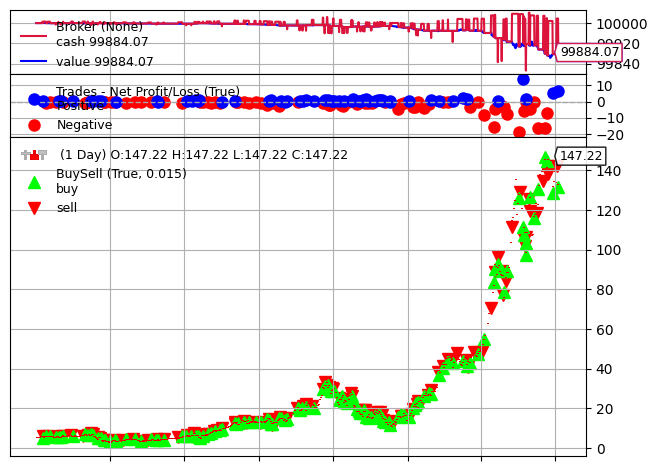

In [75]:
bt_data = data[['NVDA']].copy()
bt_data.columns = ['close']
bt_data['open'] = bt_data['close']
bt_data['high'] = bt_data['close']
bt_data['low'] = bt_data['close']
bt_data['volume'] = 0  

engine = BacktestEngine(bt_data)
final_value = engine.run()
engine.analyze()

## Parameter Optimization
Optimize ML model parameters and position sizing.

In [76]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'rfc__n_estimators': [50, 100, 200],
    'knn__n_neighbors': [3, 5, 7],
    'lsvc__C': [0.1, 0.5, 1.0]
}

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_train, y_train)

print("\nBest Parameters:", grid_search.best_params_)
print("Optimized Accuracy:", grid_search.best_score_)


Best Parameters: {'knn__n_neighbors': 7, 'lsvc__C': 0.5, 'rfc__n_estimators': 50}
Optimized Accuracy: 0.5181818181818182
